# Project 3
## Tasks 1 and 2

Task 1 was simply to install torch and torchvision, which was trivial. The rest of this section covers Task 2.

I mostly stuck to the code in the tutorial, since it does the job and is already written. But I'll go ahead and explain what is happening in each block to show that I am not just being lazy.

This next section is just setting up the imports for the task and loading the training and test data using the built-in functions for the FashionMNIST dataset. I didn't go through MNIST number set, since I have already analyzed those data using keras and tensorflow in previous workshops. The FashionMNIST set was much more interesting to me.

In [1]:
import torch

from numpy.random import default_rng
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.notebook import trange

import matplotlib.pyplot as plt
import numpy as np

# custom function imports
from task2_functions import CNeuralNetwork, NeuralNetwork, train, test, explore_wrong_5x5


training_data = datasets.FashionMNIST(root="data",
                                      train=True,
                                      download=True,
                                      transform=ToTensor())

test_data = datasets.FashionMNIST(root="data",
                                      train=False,
                                      download=True,
                                      transform=ToTensor())

I wrote this next section just to explore the data a bit. It grabs a random image and displays it.

Coat


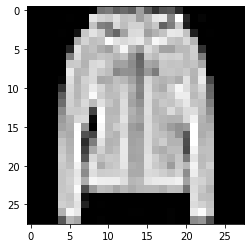

In [2]:
# Run this to explore random data

rng = default_rng()
slct = rng.integers(training_data.data.shape[0])

plt.imshow(training_data.data[slct], cmap='gray');
print(training_data.classes[training_data.targets[slct]])

This next block comes from the tutorial. It is demonstrating how you can instantiate a DataLoader object by using just a Dataset and specifying batch_size. The code prints some basic info about the output tensor.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# This is written this way to show the form of the loop.
# X is a batch of data
# y is the labels for the data
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


The next block is showing that I have cuda available and setting my device to cuda. I am doing this assignment on a fairly powerful desktop with an NVIDA Quadro RTX 5000.

In [4]:
# Verify that cuda is available

device = "cuda"  # If cuda is available!
torch.cuda.is_available()

True

Here I am moving the neural network from the tutorial to the GPU and printing its architecture. It's a basic fully connected network with a couple of hidden layers.

In [5]:
model = NeuralNetwork().to(device)  
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


For training this network, I use a cross entropy loss function, which is common for classification tasks and what is what the tutorial suggests. I use stochastic gradient descent to tune the model's parameters, with a learning rate of 0.001, as the tutorial suggests.

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # Stochastic Gradient Descent

Training is using functions mostly copied from the tutorial, with some tweaks to be less chatty. I am also using `tqdm` with jupyter widgets to produce a nice progress bar. This won't show up nicely in the pdf output.

The `train` and `test` functions here are pretty similar to one another in that they are just running the model over data, except `train` runs the model in "train" mode and adjusts model weights (train mode will also configure certain layers to, e.g., dropout some elements as part of training), whereas `test` runs the model in "eval" mode, which just computes the output layer without adjusting weights (or, e.g., dropping out elements). Of course the `train` function also differs in that it is adjusting model parameters with the optimizer.

Both functions take the dataloaders, model, and loss function object as parameters. `train` also takes the configured optimizer because that is what is used to adjust the model parameters during training.

In [7]:
# This ran at about 7s per epoch

epochs = 15
for t in trange(epochs):
    train(device, train_dataloader, model, loss_fn, optimizer)
    test(device, test_dataloader, model, loss_fn)

  0%|          | 0/15 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 44.2%, Avg loss: 2.148984 

Test Error: 
 Accuracy: 56.2%, Avg loss: 1.865914 

Test Error: 
 Accuracy: 61.9%, Avg loss: 1.503184 

Test Error: 
 Accuracy: 63.6%, Avg loss: 1.250505 

Test Error: 
 Accuracy: 64.8%, Avg loss: 1.089358 

Test Error: 
 Accuracy: 65.5%, Avg loss: 0.982883 

Test Error: 
 Accuracy: 66.6%, Avg loss: 0.910121 

Test Error: 
 Accuracy: 67.7%, Avg loss: 0.858150 

Test Error: 
 Accuracy: 68.7%, Avg loss: 0.819118 

Test Error: 
 Accuracy: 69.9%, Avg loss: 0.788391 

Test Error: 
 Accuracy: 71.2%, Avg loss: 0.762999 

Test Error: 
 Accuracy: 72.4%, Avg loss: 0.741151 

Test Error: 
 Accuracy: 73.6%, Avg loss: 0.721756 

Test Error: 
 Accuracy: 74.6%, Avg loss: 0.704136 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.687961 



I wrote a function to explore the "wrong" guesses from the model, to better understand why the model might be failing. It grabs 25 random wrong-guess images from a dataset and prints the model guess against ground truth for each. It's not very efficient but it works.

In many cases, I would argue that the guesses are pretty close, if not better than ground truth (e.g., pullover vs shirt). So this model is pretty good, even though the formal accuracy is only converges to 75-80%. It would be interesting to see what the agreement between two humans would be for a given item.

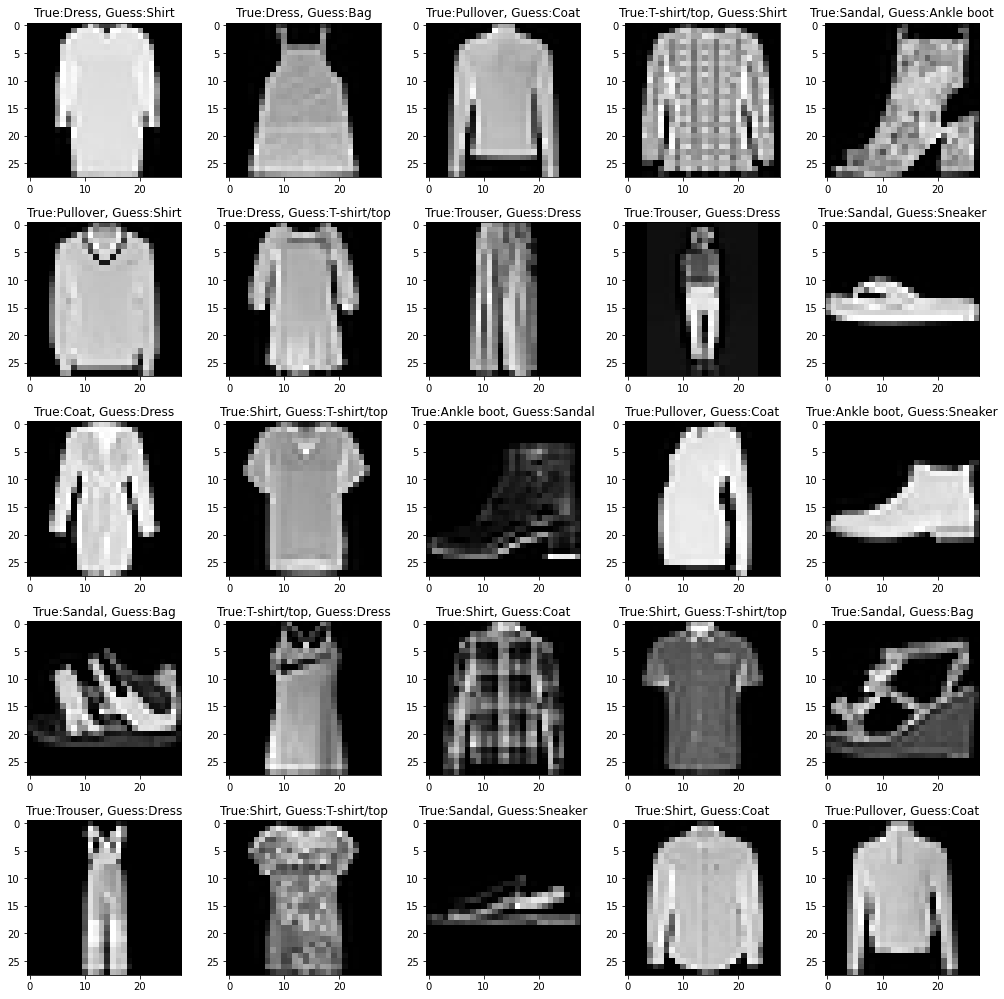

In [8]:
# Run this to explore random wrong answers

explore_wrong_5x5(train_dataloader, model, device, class_labels=training_data.classes, seed=90210)

I tried creating a better model using a convolutional neural network approach. I mostly played around with parameters until I got something that converged. This model not only converged, but it outperformed the example model:

In [9]:
# Define model
model2 = CNeuralNetwork().to(device)  
print(model2)

CNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): ReLU()
    (2): Conv2d(16, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): ReLU()
    (4): Conv2d(256, 512, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [10]:
# This ran about 17s per epoch

optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)  # Stochastic Gradient Descent

epochs = 25
for t in trange(epochs):
    train(device, train_dataloader, model2, loss_fn, optimizer)
    test(device, test_dataloader, model2, loss_fn)

  0%|          | 0/25 [00:00<?, ?it/s]

Test Error: 
 Accuracy: 10.2%, Avg loss: 2.292900 

Test Error: 
 Accuracy: 32.9%, Avg loss: 2.279721 

Test Error: 
 Accuracy: 35.0%, Avg loss: 2.253084 

Test Error: 
 Accuracy: 37.1%, Avg loss: 2.178950 

Test Error: 
 Accuracy: 48.9%, Avg loss: 1.861548 

Test Error: 
 Accuracy: 60.1%, Avg loss: 1.241123 

Test Error: 
 Accuracy: 65.5%, Avg loss: 0.977778 

Test Error: 
 Accuracy: 69.3%, Avg loss: 0.866350 

Test Error: 
 Accuracy: 72.4%, Avg loss: 0.792667 

Test Error: 
 Accuracy: 73.9%, Avg loss: 0.738054 

Test Error: 
 Accuracy: 75.0%, Avg loss: 0.699766 

Test Error: 
 Accuracy: 75.6%, Avg loss: 0.673206 

Test Error: 
 Accuracy: 76.4%, Avg loss: 0.653841 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.638019 

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.623887 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.610763 

Test Error: 
 Accuracy: 78.5%, Avg loss: 0.598278 

Test Error: 
 Accuracy: 78.9%, Avg loss: 0.586238 

Test Error: 
 Accuracy: 79.3%, Avg loss: 0.574644 

Test Error: 

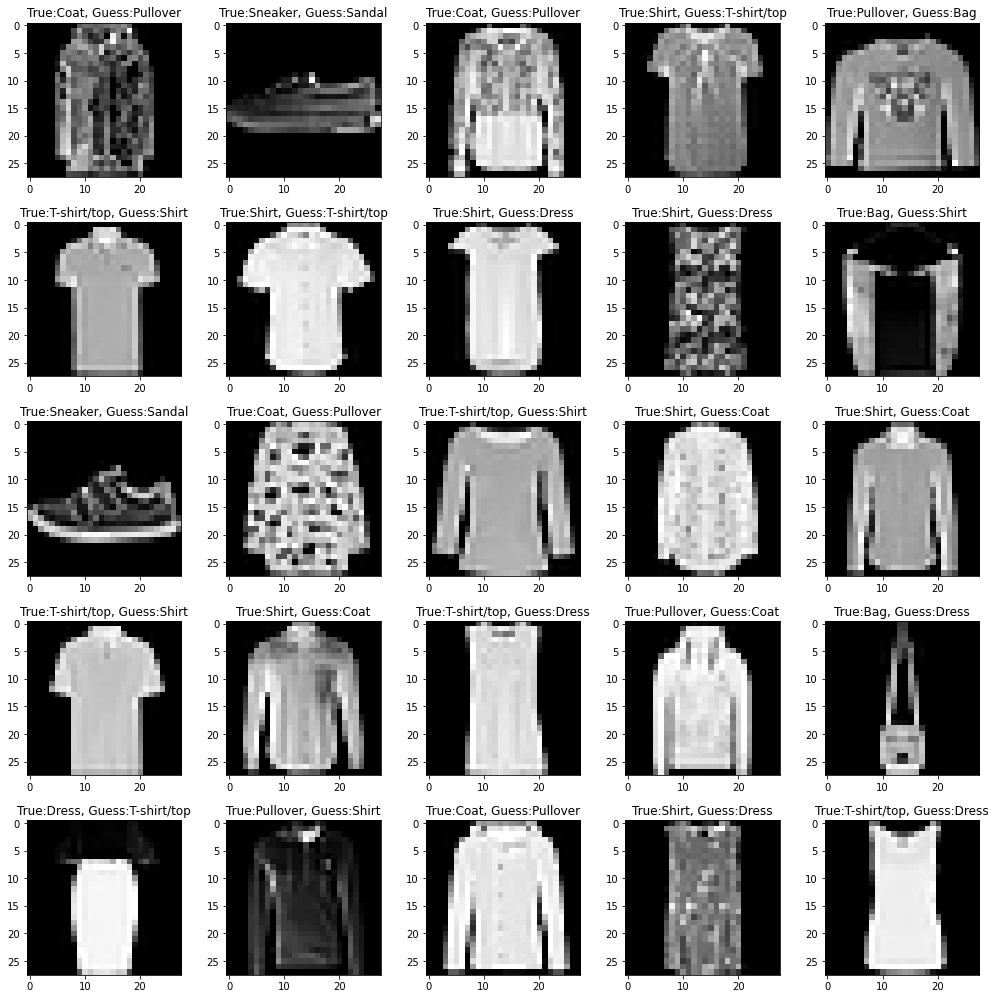

In [11]:
explore_wrong_5x5(train_dataloader, model2, device, class_labels=training_data.classes, seed=90210)

In [12]:
torch.save(model2, 'models/mycnn')

The best run of my CNN model is here:

In [13]:
model3 = torch.load('models/mycnn_best')
test(device, test_dataloader, model3, loss_fn)

Test Error: 
 Accuracy: 81.3%, Avg loss: 0.508019 



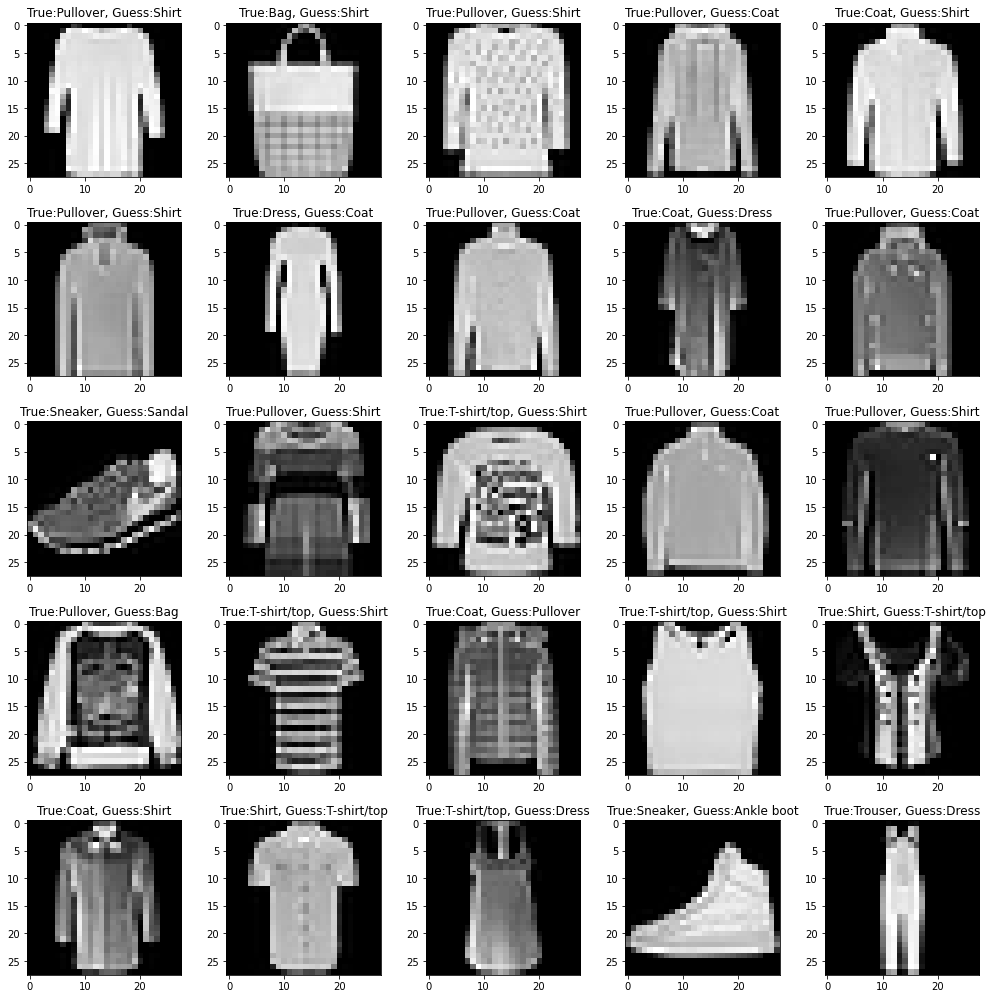

In [14]:
explore_wrong_5x5(train_dataloader, model3, device, class_labels=training_data.classes, seed=12345)

All in all, this wasn't a terrible model. I could have improved it by playing with the model parameters, or trying some more complicated architectures.